In [1]:
# pip install optuna

In [2]:
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd
import polars as pl
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import shap

In [3]:
dir = r"C://Users//Jota//Documents//Chingven"

train_df = pl.read_csv(dir+"//training_full.csv")
test_df =pl.read_csv(dir+"//testing_full.csv")

In [4]:
train_df = train_df.drop('')
test_df = test_df.drop('')

In [5]:
def preprocess(df):
    impaired_list = [col for col in train_df.columns if col.startswith('impaired')]
    feature_df = df.drop(['SEQN', 'func_score'] + impaired_list)
    target_df = df.select(pl.col(impaired_list[:3]))
    print(f"Feature shape = {feature_df.shape}")
    print(f"Target shape = {target_df.shape}")
    return feature_df, target_df

In [6]:
x_train, y_train = preprocess(train_df)
print()
x_test, y_test = preprocess(test_df)

x_train = x_train.to_pandas()
x_test = x_test.to_pandas()
y_train = y_train.to_pandas()
y_test = y_test.to_pandas()

Feature shape = (2221, 22)
Target shape = (2221, 3)

Feature shape = (556, 22)
Target shape = (556, 3)


# Modeling: Catboost baseline

In [7]:
from sklearn.metrics import roc_auc_score

def result(predict,y_test):
    print("")
    test_auc = roc_auc_score(y_test, predict[:, 1])
    print(f"Testing AUC: {round(test_auc, 4)}")

In [8]:
device = 'CPU'
targets = [f'impaired_{i}' for i in range(1, 4)]
random_state = 1024

In [9]:
for target in targets:
    model = CatBoostClassifier(task_type=device, silent = True, random_state=random_state)
    model.fit(x_train, y_train[target])
    y_pred = model.predict_proba(x_test)
    
    print(f"Target Variable: {target}")
    print("")
    display(y_test[target].value_counts())
    result(y_pred, y_test[target])
    print("="*50)

Target Variable: impaired_1



impaired_1
0    520
1     36
Name: count, dtype: int64


Testing AUC: 0.6554
Target Variable: impaired_2



impaired_2
0    545
1     11
Name: count, dtype: int64


Testing AUC: 0.6043
Target Variable: impaired_3



impaired_3
0    553
1      3
Name: count, dtype: int64


Testing AUC: 0.7505


# Modeling: Catboost with Optuna

In [10]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'iterations':  trial.suggest_int('iterations', 900, 1300),
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.10),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.01, 10.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0)
    }
    

    optuna_model = CatBoostClassifier(**params, task_type=device, silent = True, random_state=random_state)
    optuna_model.fit(x_train, y_train[target])
    y_pred = optuna_model.predict_proba(x_test)
    test_auc = roc_auc_score(y_test[target], y_pred[:, 1])
    return test_auc

In [11]:
def optuna_plot(study):
    fig = optuna.visualization.plot_parallel_coordinate(study)
    fig1 = optuna.visualization.plot_param_importances(study)
    fig.show()
    fig1.show()

In [12]:
def best_params(study):
    print()
    print(f'Trials = {len(study.trials)}')
    trial = study.best_trial
    print(f'Best trial result = {trial.value}')
    print('  Hyper-Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

#     optuna_plot(study)
    return trial

In [13]:
best_trial = []
n_trials = 1000

In [14]:
%%time

for target in targets:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, gc_after_trial=True)
    print("")
    print(f"Target Variable: {target}")
    print("")
    trial = best_params(study)
    best_trial.append(trial)
    print("="*200)


Target Variable: impaired_1


Trials = 1000
Best trial result = 0.7085470085470086
  Hyper-Params: 
    iterations: 1049
    learning_rate: 0.018610504170298223
    max_depth: 6
    l2_leaf_reg: 9.991757009521887
    subsample: 0.9585616248838793

Target Variable: impaired_2


Trials = 1000
Best trial result = 0.7336113427856548
  Hyper-Params: 
    iterations: 1094
    learning_rate: 0.008090649786641209
    max_depth: 4
    l2_leaf_reg: 0.9382256996676364
    subsample: 0.43396284753936515

Target Variable: impaired_3


Trials = 1000
Best trial result = 0.9005424954792043
  Hyper-Params: 
    iterations: 1245
    learning_rate: 0.038747872568952825
    max_depth: 6
    l2_leaf_reg: 0.17346403267071028
    subsample: 0.5011542229700523
CPU times: total: 2h 11min 28s
Wall time: 2h 33min 46s


# Final Result

In [15]:
models = []
y_pred_list = []
for i, target in enumerate(targets):
    params = best_trial[i].params
    model = CatBoostClassifier(**params, task_type=device, silent=True, random_state=1024)
    model.fit(x_train, y_train[target])
    y_pred = model.predict_proba(x_test)
    y_pred_list.append(y_pred)
    models.append(model)
    
    print(f"Target Variable: {target}")
    result(y_pred, y_test[target])
    print("="*50)

Target Variable: impaired_1

Testing AUC: 0.7085
Target Variable: impaired_2

Testing AUC: 0.7336
Target Variable: impaired_3

Testing AUC: 0.9005


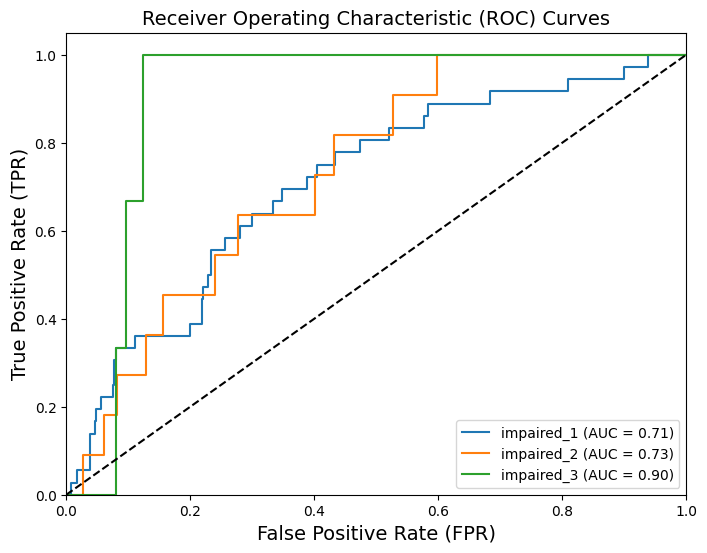

In [16]:
y_true_list = [y_test[target] for target in targets]
y_pred_list = [model.predict_proba(x_test)[:, 1] for model in models]  
plt.figure(figsize=(8, 6))
for i, target in enumerate(targets):
    y_true = y_true_list[i]
    y_pred_prob = y_pred_list[i]

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(target, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=14)
plt.legend(loc="lower right")
plt.show()

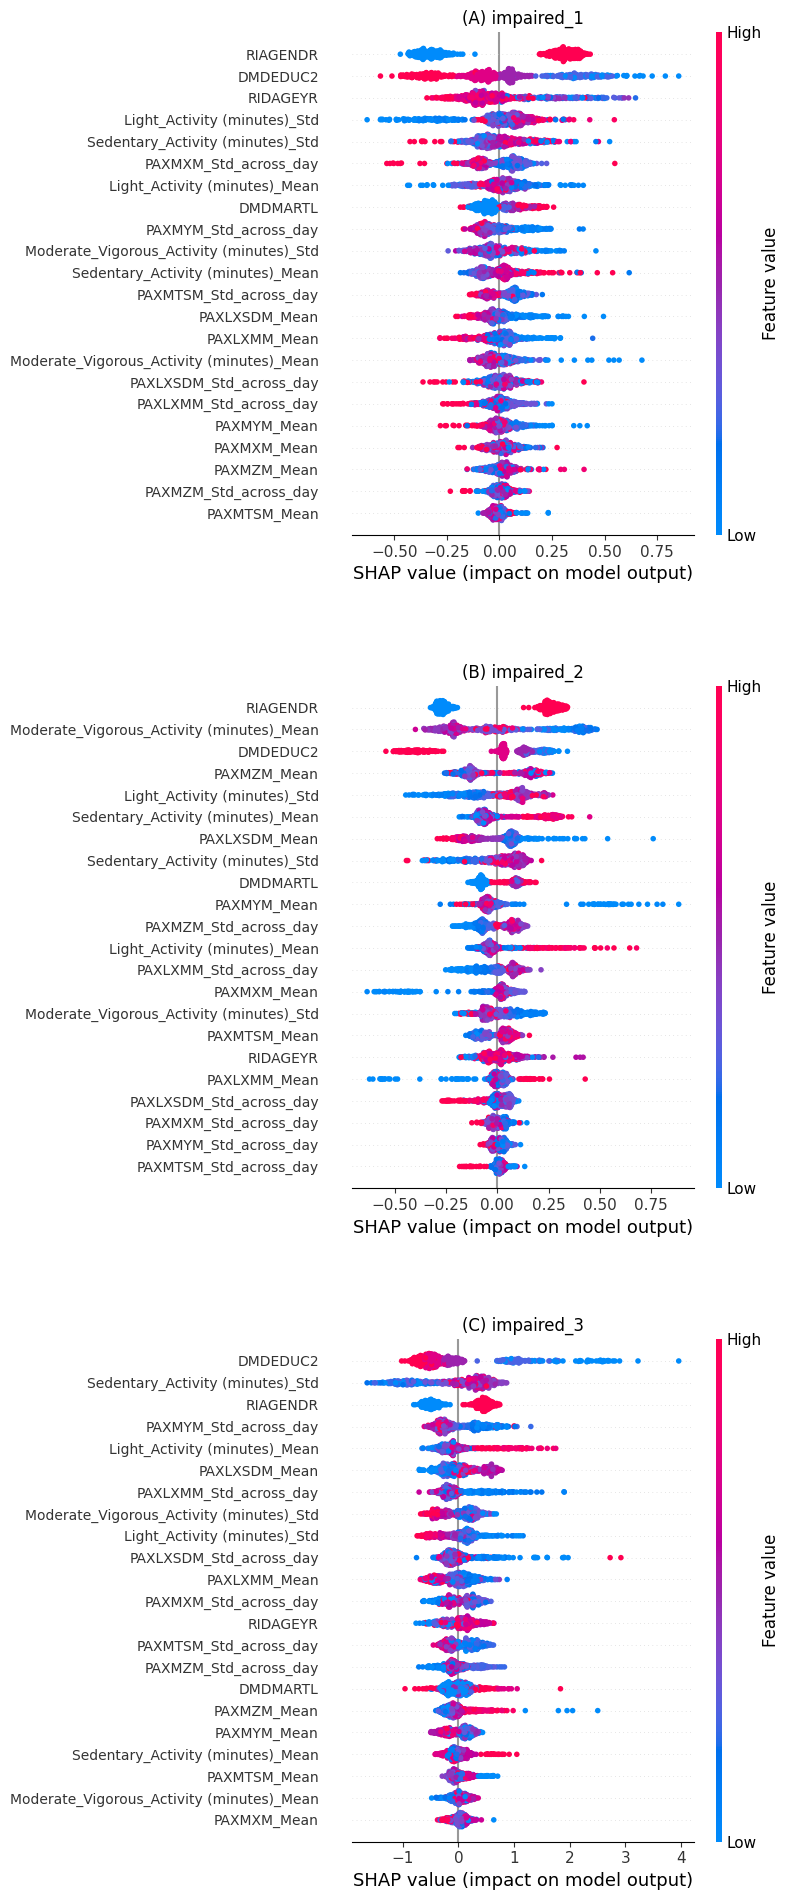

In [17]:
fig, axs = plt.subplots(len(targets), 1, figsize=(8,6*len(targets)))

for i, (target, model) in enumerate(zip(targets, models)):
    explainer = shap.Explainer(model)
    shap_values = explainer(x_test)

    ax = axs[i]
    plt.subplot(len(targets), 1, i+1)
    shap.plots.beeswarm(shap_values, max_display=70,show=False, plot_size=0.8)

    plt.title(f'({chr(65 + i)}) {target}', fontsize=12)
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()